In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("imagefolder", data_dir="/data_vault/hexai/ArtEmis-FinalSplits/")

label2id = {label: i for i, label in enumerate(dataset["train"].features["label"].names)}
id2label = {i: label for label, i in label2id.items()}

Resolving data files:   0%|          | 0/13311 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1903 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3806 [00:00<?, ?it/s]

In [3]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [4]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [5]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [6]:
data_vit = dataset.with_transform(transforms)

In [7]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import numpy as np
def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        # Calculate accuracy
        accuracy = accuracy_score(labels, predictions)

        # Calculate precision, recall, and F1-score
        precision = precision_score(labels, predictions, average='macro')
        recall = recall_score(labels, predictions, average='macro')
        f1 = f1_score(labels, predictions, average='macro')

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

In [13]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained("vit_best").cuda()

In [9]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [11]:
for param in model.vit.parameters():
    param.requires_grad = False

In [12]:
training_args = TrainingArguments(
    output_dir="artemis_ViT/",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-03,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=data_vit["train"],
    eval_dataset=data_vit["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,1.830100,1.843049,0.283237,0.268664,0.223568,0.195089
1,1.780500,1.770737,0.318445,0.300440,0.265875,0.256396
2,1.722200,1.738711,0.327378,0.289936,0.277946,0.270110
4,1.738100,1.725204,0.335786,0.292572,0.286943,0.280054
5,1.738400,1.720567,0.327378,0.283126,0.280416,0.273603
6,1.739800,1.708989,0.344719,0.307168,0.296207,0.291442
8,1.707800,1.714725,0.334209,0.287622,0.285720,0.278852
9,1.721700,1.703169,0.347872,0.301175,0.300960,0.294482


/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ngl18/anaconda3/envs/lo

TrainOutput(global_step=340, training_loss=1.7446798976729898, metrics={'train_runtime': 4988.2305, 'train_samples_per_second': 26.685, 'train_steps_per_second': 0.068, 'total_flos': 1.009479140500549e+19, 'train_loss': 1.7446798976729898, 'epoch': 9.78})

In [13]:
trainer.evaluate(data_vit["test"])

/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.7012816667556763,
 'eval_accuracy': 0.3486600105097215,
 'eval_precision': 0.29913181600920336,
 'eval_recall': 0.29741734156409877,
 'eval_f1': 0.28985718498798047,
 'eval_runtime': 86.5295,
 'eval_samples_per_second': 43.985,
 'eval_steps_per_second': 0.462,
 'epoch': 9.78}

In [14]:
for param in model.vit.parameters():
    param.requires_grad = True

In [15]:
training_args = TrainingArguments(
    output_dir="artemis_ViT-unfrozen-2/",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-05,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=data_vit["train"],
    eval_dataset=data_vit["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,1.677300,1.695733,0.352601,0.302663,0.308378,0.300846
1,1.644300,1.680769,0.354703,0.310152,0.304786,0.298005
2,1.584100,1.667573,0.359432,0.314656,0.318335,0.311292
4,1.514500,1.671755,0.352601,0.300724,0.310002,0.301611
5,1.490000,1.685259,0.346821,0.331596,0.304778,0.299265
6,1.446900,1.673433,0.364162,0.317417,0.319611,0.314260
8,1.417600,1.686587,0.357856,0.309215,0.313016,0.306586
9,1.432400,1.676843,0.358382,0.339880,0.317454,0.313203


/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was a

TrainOutput(global_step=340, training_loss=1.529821320141063, metrics={'train_runtime': 3519.2166, 'train_samples_per_second': 37.824, 'train_steps_per_second': 0.097, 'total_flos': 1.009479140500549e+19, 'train_loss': 1.529821320141063, 'epoch': 9.78})

In [16]:
trainer.evaluate(data_vit["test"])

/home/ngl18/anaconda3/envs/lora/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.646568775177002,
 'eval_accuracy': 0.37729900157645824,
 'eval_precision': 0.35545552865392754,
 'eval_recall': 0.3315824508535328,
 'eval_f1': 0.32609698442206536,
 'eval_runtime': 67.887,
 'eval_samples_per_second': 56.064,
 'eval_steps_per_second': 0.589,
 'epoch': 9.78}

In [23]:
preds, labels = [], []
for batch in data_vit["test"]:
    pix_val = batch["pixel_values"].cuda()
    out = model(pix_val.unsqueeze(dim=0))
    predictions = np.argmax(out.logits.detach().cpu().numpy(), axis=-1)
    preds.extend(predictions)
    labels.append(batch["label"])

In [34]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.35      0.38      0.37       708
           1       0.42      0.52      0.47       680
           2       0.27      0.01      0.03       208
           3       0.35      0.45      0.39       759
           4       0.38      0.31      0.34       454
           5       0.33      0.33      0.33       516
           6       0.37      0.26      0.31       481

    accuracy                           0.37      3806
   macro avg       0.35      0.32      0.32      3806
weighted avg       0.36      0.37      0.36      3806



In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, labels):
    """
    Plots the confusion matrix (thanks to Dr. Na-Rae Han).
    """
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="Reds", 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()


In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
cm = confusion_matrix(labels, preds)

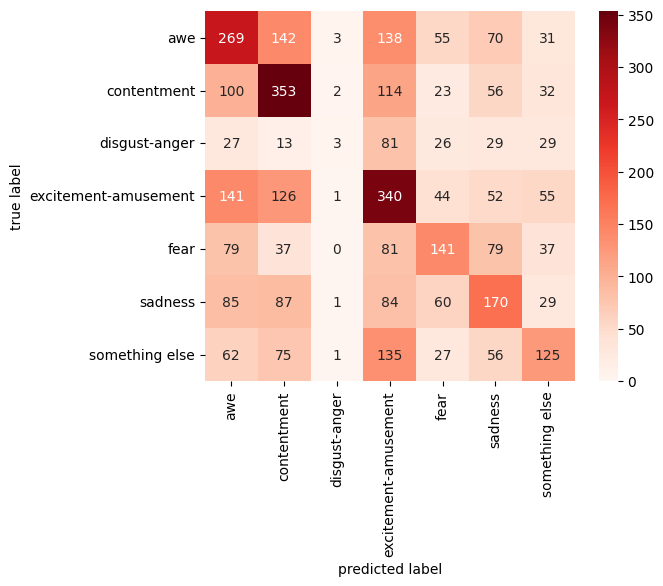

In [38]:
plot_confusion_matrix(cm, id2label.values())

In [40]:
from imblearn.metrics import specificity_score
print(1 - specificity_score(labels, preds, average="macro"))

0.10872803940692888


In [23]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [24]:
trainer.save_model("vit_best")